In [2]:
# Import modules and load the dataframe with job information
from gpu_metrics import GPUMetrics
import matplotlib.pyplot as plt
import pandas as pd

import duckdb

%matplotlib inline
import seaborn as sns

sns.set_theme()
sns.set_palette("muted")
# Filter out jobs less than 10 minutes
metrics = GPUMetrics(min_elapsed=600)
df = metrics.df

First we take a look at average and median queue wait times for jobs, based on how much GPU VRam they request.

In [3]:
df["queued_seconds"] = df["Queued"].apply(lambda x: x.total_seconds())
df["total_seconds"] = df["Elapsed"] + df["queued_seconds"]

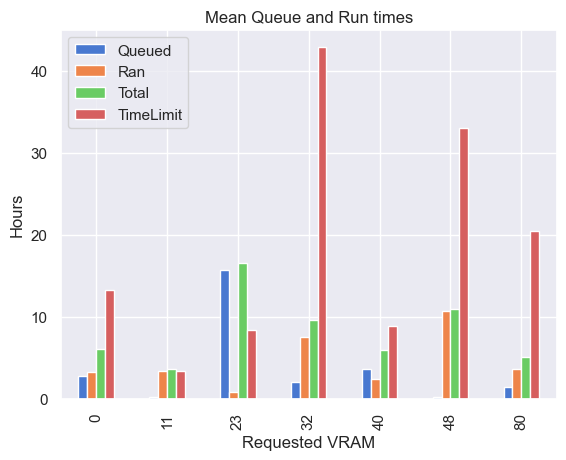

In [4]:
def plot_queued(stat="Mean"):
    """Plot Queue statistics"""
    gb = df[~df["IsArray"] & (df["GPUs"] == 1)].groupby(["requested_vram"])[
        ["queued_seconds", "Elapsed", "total_seconds", "TimeLimit"]
    ]
    if stat == "Mean":
        gb = gb.mean()
    elif stat == "Median":
        gb = gb.median()

    plotting_df = gb / 3600
    plotting_df["TimeLimit"] *= 60
    plotting_df.rename(
        columns={"queued_seconds": "Queued", "total_seconds": "Total", "Elapsed": "Ran"}
    ).plot.bar()
    plt.title(stat + " Queue and Run times")
    plt.xlabel("Requested VRAM")
    plt.ylabel("Hours")
    plt.show()


plot_queued()

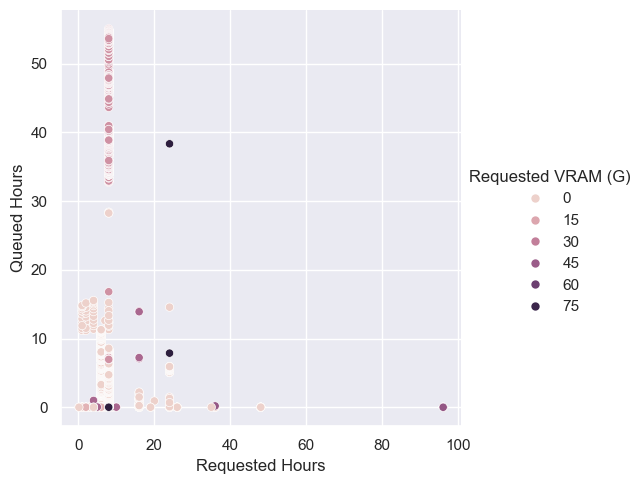

In [5]:
def do_relplot():
    """Plot relationship between timelimit and queue time"""
    mask = ~df["IsArray"] & (df["GPUs"] == 1) & (df["Partition"] == "gpu")
    plotting_df = pd.DataFrame(
        {
            "Queued Hours": df["queued_seconds"][mask] / 3600,
            "Requested Hours": df["TimeLimit"][mask] / 60,
            "Requested VRAM (G)": df["requested_vram"][mask],
        }
    ).clip(0, 100)
    sns.relplot(data=plotting_df, x="Requested Hours", y="Queued Hours", hue="Requested VRAM (G)")
    # plt.plot("Queued vs Requested Hours on Unity")
    # plt.show()


do_relplot()

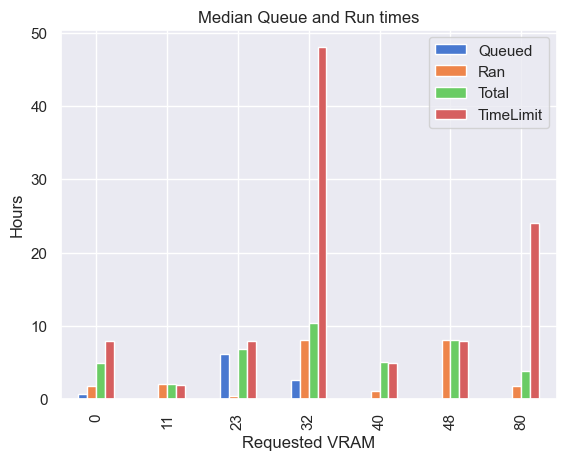

In [6]:
plot_queued(stat="Median")

Next we examine VRAM usage levels for all jobs, jobs with no specific VRAM request, and for jobs that request the largest GPU possible (80G) of VRAM.

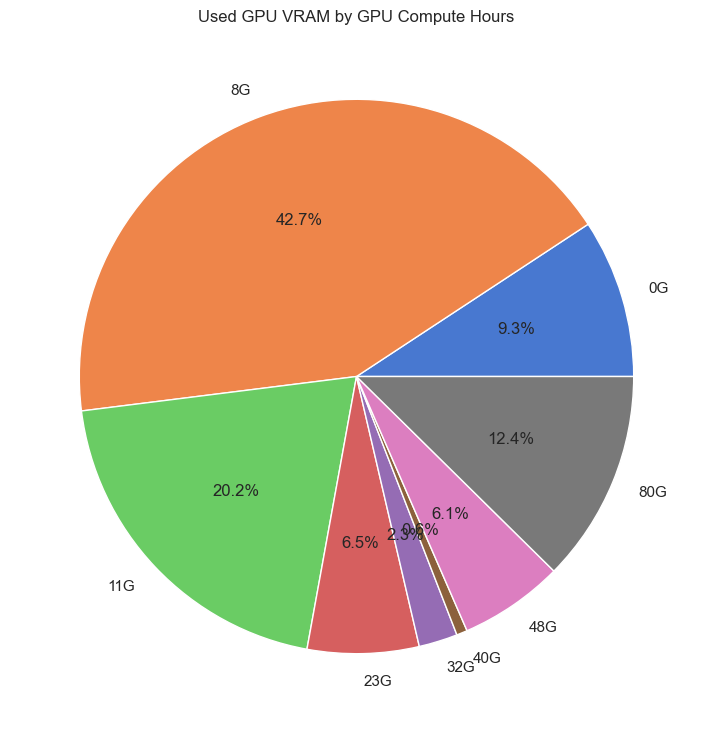

In [7]:
from gpu_metrics import vram_cutoffs, vram_labels


def efficiency_plot(constrs=[], title="Used GPU VRAM by GPU Compute Hours"):
    if len(constrs):
        where = "where " + (" and ".join(constrs))
    else:
        where = ""
    filtered_df = duckdb.query(
        "select GPUs, GPUMemUsage, Elapsed, requested_vram, IsArray"
        ", Elapsed*GPUs/3600 as gpu_hours "
        " from df " + where
    ).df()
    filtered_df["used_vram"] = pd.cut(
        filtered_df["GPUMemUsage"] / 2**30, labels=vram_labels, bins=vram_cutoffs
    )
    # filtered_df.groupby(["requested_vram", "IsArray"])["gpu_hours"].sum()
    filtered_df.loc[(filtered_df["used_vram"] == 12), "used_vram"] = 11
    filtered_df.loc[(filtered_df["used_vram"] == 16), "used_vram"] = 23
    tot_hours = filtered_df.groupby(["used_vram"], observed=False)["gpu_hours"].sum().reset_index()
    tot_hours = tot_hours[tot_hours["gpu_hours"] > 0]
    tot_hours.plot.pie(
        figsize=(9, 9),
        legend=False,
        y="gpu_hours",
        labels=[f"{i}G" for i in tot_hours["used_vram"]],
        autopct="%1.1f%%",
    )
    # tot_hours.plot.pie()
    plt.ylabel("")
    plt.title(title)
    plt.show()


efficiency_plot()

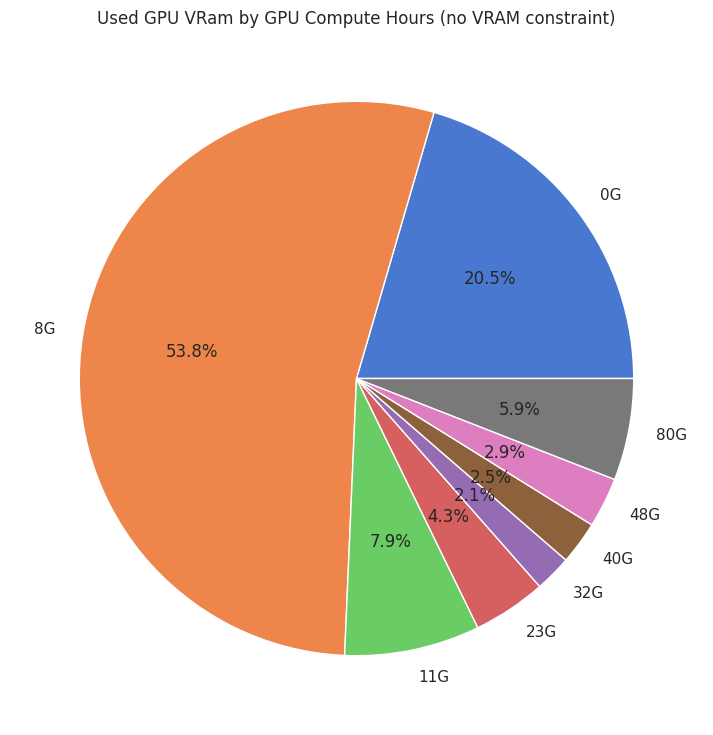

In [8]:
efficiency_plot(
    constrs=["requested_vram=0"], title="Used GPU VRam by GPU Compute Hours (no VRAM constraint)"
)

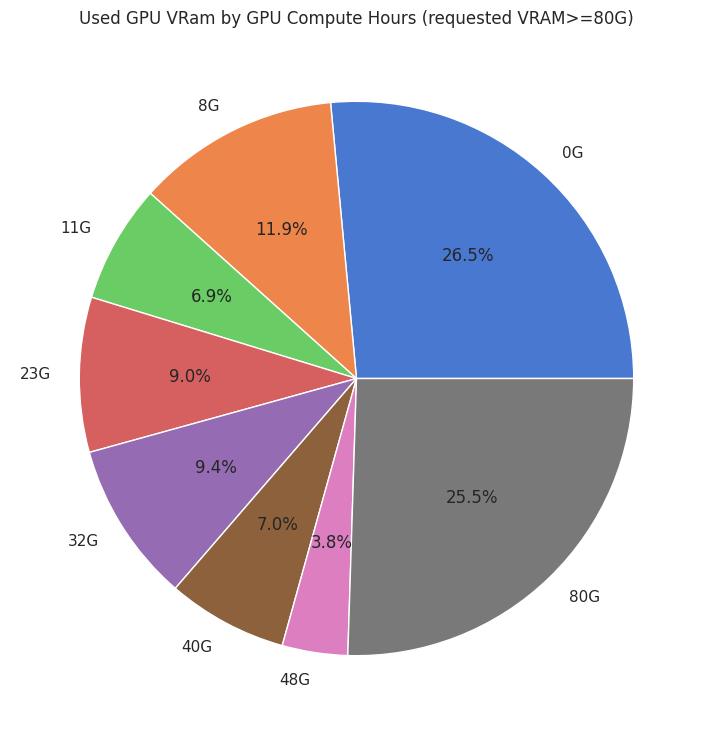

In [9]:
efficiency_plot(
    constrs=["requested_vram>=80", "partition!='superpod-a100'"],
    title="Used GPU VRam by GPU Compute Hours (requested VRAM>=80G)",
)